## Setup Kaggle CLI inside Colab

In [1]:
! pip install -Uq kaggle
! pip install -Uq fastai==2.2.5

     |████████████████████████████████| 194kB 5.5MB/s 
     |████████████████████████████████| 61kB 4.9MB/s 


In [2]:
from google.colab import files 
files.upload()

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### Download Dataset
Unfortunately from [Official competition page](https://www.kaggle.com/c/planet-understanding-the-amazon-from-space/overview) we can not download the dataset for some reasons. One can confirm this with below commnad.

In [4]:
!kaggle competitions files -c planet-understanding-the-amazon-from-space

name                                                size  creationDate         
-------------------------------------------------  -----  -------------------  
sample_submission_v2.csv/sample_submission_v2.csv    3MB  2019-12-15 22:14:13  
train_v2.csv/train_v2.csv                            1MB  2019-12-15 22:14:13  
test_v2_file_mapping.csv/test_v2_file_mapping.csv  600KB  2019-12-15 22:14:13  
Kaggle-planet-train-tif.torrent                      1MB  2019-12-15 22:14:13  
Kaggle-planet-test-tif.torrent                       2MB  2019-12-15 22:14:13  


But thanks to [**nik**](https://www.kaggle.com/nikitarom), he hosted the [*dataset*](https://www.kaggle.com/nikitarom/planets-dataset). 

In [5]:
! kaggle datasets download nikitarom/planets-dataset

 99% 1.49G/1.50G [00:45<00:00, 33.4MB/s]
100% 1.50G/1.50G [00:45<00:00, 35.4MB/s]


### Extract the archive

In [6]:
!unzip planets-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: test-jpg-additional/test-jpg-additional/file_5499.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_55.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_550.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5500.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5501.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5502.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5503.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5504.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5505.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5506.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5507.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5508.jpg  
  inflating: test-jpg-additional/test-jpg-additional/file_5509.jpg  
  inflating: test-jpg-additional/test-jpg-additional/fi

## Importing necessary modules

In [7]:
from fastai.vision.all import *
path = Path('./planet/planet')

In [8]:
path.ls()

(#4) [Path('planet/planet/train_classes.csv'),Path('planet/planet/sample_submission.csv'),Path('planet/planet/test-jpg'),Path('planet/planet/train-jpg')]

In [9]:
train_df = pd.read_csv(path/'train_classes.csv')
train_df

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road
...,...,...
40474,train_40474,clear primary
40475,train_40475,cloudy
40476,train_40476,agriculture clear primary
40477,train_40477,agriculture clear primary road


## Create DataLoaders from DataBlock

In [10]:
def get_data(size=224,bs=64,data_df=train_df):
    dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                       splitter=RandomSplitter(seed=42),
                       get_x=ColReader(0, pref=f'{path}/train-jpg/', suff='.jpg'),
                       get_y=ColReader(1, label_delim=' '),
                       item_tfms = Resize(size),
                       batch_tfms = [*aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.),
                                     Normalize.from_stats(*imagenet_stats)]
                      )
    return dblock.dataloaders(data_df,bs=bs)

### Dataloaders with image size 128 and batch size 256

In [11]:
dls = get_data(128,256)

### Visualize the dataset

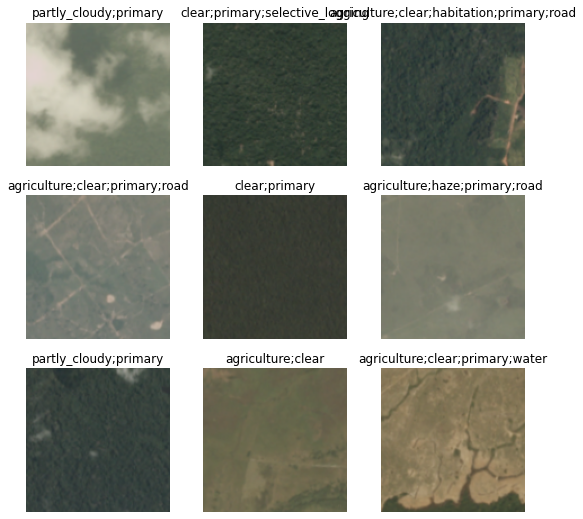

In [12]:
dls.show_batch()

### Create Learner

In [13]:
metrics = [partial(accuracy_multi, thresh=0.2), FBetaMulti(beta=2, average='samples', thresh=0.2)]
cbs = [MixUp]

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.02754228748381138)

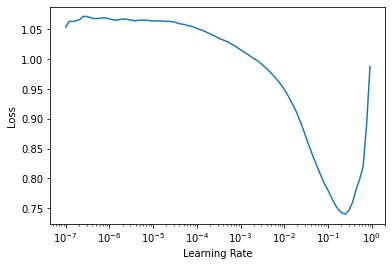

In [14]:
learn = cnn_learner(dls, resnet50, metrics=metrics, cbs=cbs).to_fp16()
learn.lr_find()

In [15]:
learn.fine_tune(6, base_lr=2e-2, freeze_epochs=4)

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.363864,0.134002,0.935276,0.882574,03:32
1,0.187601,0.119348,0.940893,0.896279,03:29
2,0.165761,0.110958,0.939687,0.897990,03:28
3,0.152638,0.101296,0.954627,0.912946,03:28


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.146192,0.097965,0.952011,0.917079,04:18
1,0.146534,0.108141,0.938430,0.906440,04:17
2,0.142190,0.098184,0.950340,0.918730,04:17
3,0.137673,0.091665,0.955034,0.921967,04:16
4,0.132637,0.086524,0.957076,0.927407,04:15


epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.146192,0.097965,0.952011,0.917079,04:18
1,0.146534,0.108141,0.938430,0.906440,04:17
2,0.142190,0.098184,0.950340,0.918730,04:17
3,0.137673,0.091665,0.955034,0.921967,04:16
4,0.132637,0.086524,0.957076,0.927407,04:15
5,0.128837,0.085645,0.957403,0.927058,04:16


In [16]:
learn.save('resnet50-128')

Path('models/resnet50-128.pth')

### Dataloaders with image size 256 and batch size 128

SuggestedLRs(lr_min=1.9054607491852948e-07, lr_steep=7.585775847473997e-07)

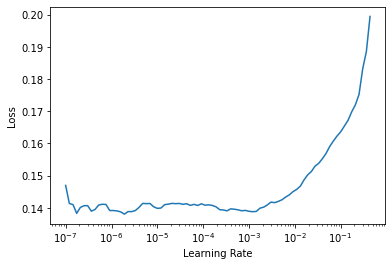

In [17]:
dls = get_data(256, 128)
learn.dls = dls
learn.lr_find()

In [18]:
learn.fit_one_cycle(6, slice(2e-5, 2e-4))

epoch,train_loss,valid_loss,accuracy_multi,fbeta_score,time
0,0.134069,0.086246,0.956567,0.926283,14:03
1,0.133321,0.085230,0.957475,0.927440,14:01
2,0.129200,0.084651,0.957912,0.928630,14:02
3,0.128616,0.083970,0.958725,0.928293,14:00
4,0.129413,0.083631,0.958246,0.928969,14:04
5,0.126237,0.083676,0.958420,0.929480,14:04


In [19]:
learn.save('resnet50-256')

Path('models/resnet50-256.pth')

### Dataloaders with image size 512 and batch size 64

In [20]:
#dls = get_data(512, 64)
#learn.dls = dls
#learn.unfreeze()
#learn.lr_find()

In [21]:
#learn.fit_one_cycle(3, slice(1e-6, 1e-5))

In [22]:
#learn.save('resnet50-512')

In [23]:
#learn.load('resnet50-256')

## Visualize the model

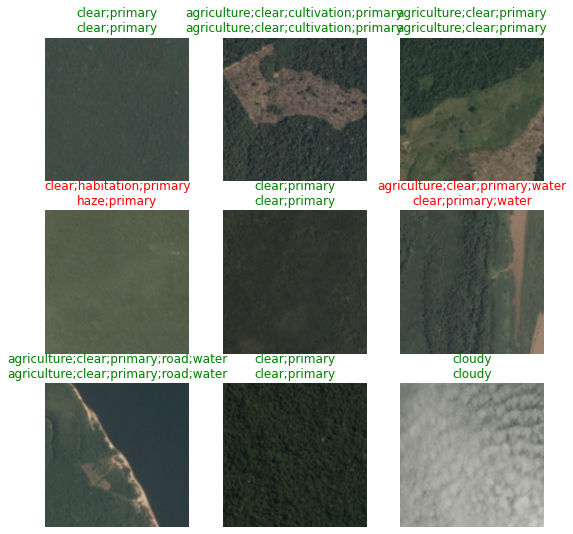

In [24]:
learn.show_results()

## Kaggle submission

In [25]:
additional_test_path = Path('test-jpg-additional/test-jpg-additional')
test_path = Path('planet/planet/test-jpg')
submission_df = pd.read_csv(path/'sample_submission.csv')
testing_path = (submission_df['image_name'] + '.jpg').apply(lambda x: test_path/x if x.startswith('test') else additional_test_path/x)

def prediction(filename='submission.csv', tta=False):
    tst_dl = learn.dls.test_dl(testing_path)
    if tta:
        predictions = learn.tta(dl = tst_dl)
    else:
        predictions = learn.get_preds(dl = tst_dl)
    predlist = [' '.join(learn.dls.vocab[i]) for i in (predictions[0] > 0.2)]

    df = submission_df
    df['tags'] = predlist

    df.to_csv(filename, index=False)
    return df

In [26]:
prediction('submission_tta.csv', tta=True)

,image_name,tags
0,test_0,clear primary
1,test_1,clear primary
2,test_2,partly_cloudy primary
3,test_3,agriculture clear partly_cloudy primary
4,test_4,cloudy partly_cloudy primary
...,...,...
61186,file_9995,cloudy partly_cloudy primary
61187,file_9996,clear primary water
61188,file_9997,clear primary road water
61189,file_9998,cloudy


In [28]:
 ! kaggle competitions submit -c planet-understanding-the-amazon-from-space -f "submission_tta.csv" -m "My second submission"

100% 2.21M/2.21M [00:07<00:00, 323kB/s]
Successfully submitted to Planet: Understanding the Amazon from Space